In [1]:
import requests
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from pycountry_convert import convert_country_alpha2_to_continent, convert_country_name_to_country_alpha2
pd.options.mode.chained_assignment = None

## `Question #1`

In [2]:
URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'
r = requests.get(URL).json()['data']
df = pd.DataFrame(r)

`For each university, we found the number of faculty members, students and international students.
We've used need the URLs of the respective unis.`

In [3]:
df_top_universities = df[['country','rank_display', 'region','title']][:200]

suffixes = np.array(df['url'])
urls = []
for suffix in suffixes:
    urls.append('https://www.topuniversities.com' + suffix + '#wurs')

def find_number(soup, tag, my_class):
    try:
        soup.find(tag, class_= my_class).find(tag, class_='number') 
    except: 
        return 0

    return int(soup.find(tag, class_= my_class).find(tag, class_='number')\
               .text.strip('\n').replace(',','').strip(' '))

staff = []
int_staff = []
students = []
intl_students = []
i = 1

for url in urls[:200]:
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
   
    faculty_staff = find_number(soup,'div','faculty-main wrapper col-md-4')
    intl_faculty_staff = find_number(soup, 'div', 'inter faculty')
    students_ = find_number(soup, 'div', 'students-main wrapper col-md-4')
    int_students = find_number(soup, 'div','int-students-main wrapper col-md-4')
    
    staff.append(faculty_staff)
    int_staff.append(intl_faculty_staff)
    students.append(students_)
    intl_students.append(int_students)
    
df_top_universities['students'] = pd.Series(students)
df_top_universities['inter_students'] = pd.Series(intl_students)
df_top_universities['staff'] = pd.Series(staff)
df_top_universities['inter_staff'] = pd.Series(int_staff)

df_top_universities['student_staff_ratio'] = df_top_universities.students\
                                             .divide(df_top_universities.staff).round(3)
df_top_universities['international_students_ratio'] = df_top_universities.inter_students\
                                                      .divide(df_top_universities.students).round(3)*100

### `(a) Ratio between faculty members and students`

In [4]:
df_top_universities = df_top_universities.sort_values(['student_staff_ratio'], ascending = True)
df_top_universities[['title','student_staff_ratio']].head()

,title,student_staff_ratio
3,California Institute of Technology (Caltech),2.366
15,Yale University,2.511
5,University of Oxford,2.921
4,University of Cambridge,3.419
16,Johns Hopkins University,3.619


### `(b) Ratio of international students`

In [5]:
df_top_universities = df_top_universities.sort_values(['international_students_ratio'], ascending=False)
df_top_universities[['title','international_students_ratio']].head()

,title,international_students_ratio
34,London School of Economics and Political Scien...,69.1
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),57.0
7,Imperial College London,54.4
198,Maastricht University,50.3
47,Carnegie Mellon University,47.8


### `(c)(1) Ratio between faculty members and students by country`

In [6]:
df_staff = df_top_universities.copy()
df_staff = df_staff.groupby('country').mean()
df_staff = df_staff.sort_values(['student_staff_ratio'])
df_staff[['student_staff_ratio']].round(3).head()

,student_staff_ratio
country,
Russia,4.506
Saudi Arabia,5.687
Singapore,6.172
Malaysia,6.498
Japan,6.566


### `(c)(2) Ratio of international students by country`

In [7]:
df_inter = df_top_universities.copy()
df_inter = df_inter.groupby('country').mean()
df_inter = df_inter.sort_values(['international_students_ratio'], ascending=False)
df_inter[['international_students_ratio']].round(3).head()

,international_students_ratio
country,
United Kingdom,35.132
Australia,34.678
Switzerland,31.371
Hong Kong,31.200
Austria,30.600


### `(d)(1) Ratio between faculty members and students by region`

In [8]:
df_staff = df_top_universities.copy()
df_staff = df_staff.groupby('region').mean()
df_staff = df_staff.sort_values(['student_staff_ratio'])
df_staff[['student_staff_ratio']].round(3)

,student_staff_ratio
region,
Asia,7.978
North America,9.214
Europe,9.874
Latin America,11.235
Africa,11.306
Oceania,13.795


### `(d)(2) Ratio of international students by region`

In [9]:
df_inter = df_top_universities.copy()
df_inter = df_inter.groupby('region').mean()
df_inter = df_inter.sort_values(['international_students_ratio'], ascending=False)
df_inter[['international_students_ratio']].round(3)

,international_students_ratio
region,
Oceania,32.900
Europe,24.592
North America,20.242
Africa,17.000
Asia,13.239
Latin America,7.186


`Plots & Analysis`

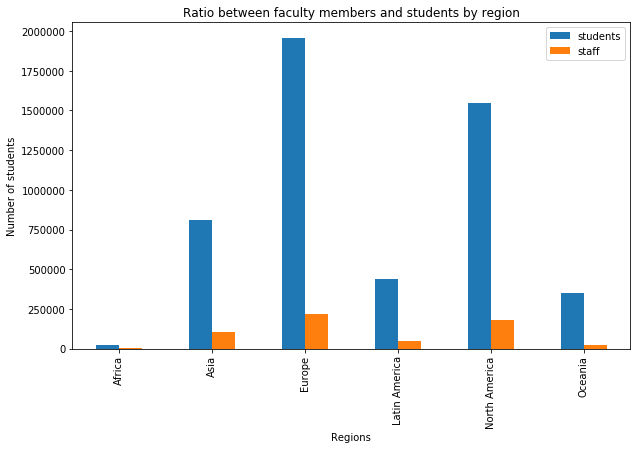

In [10]:
df_plot = df_top_universities.copy()
df_plot = df_plot.groupby('region').sum()
df_plot[['students','staff']]\
    .plot.bar(figsize=(10,6),title ='Ratio between faculty members and students by region')
plt.xlabel('Regions')
plt.ylabel('Number of students')
plt.show()

## `Question #2`

In [11]:
URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(URL).json()['data']
df = pd.DataFrame(r)

`Continents are not provided in timehighereducation.com.
We converted countries to continents using an external library.`

In [12]:
df_times_higher = df[['location','rank_order','name', 'stats_number_students', 'stats_pc_intl_students',
             'stats_student_staff_ratio']][:200]

def convert_country_name_to_continent(name):    
    alpha2 = convert_country_name_to_country_alpha2(name)
    return convert_country_alpha2_to_continent(alpha2)

df_times_higher = df_times_higher.copy()
df_times_higher['continent'] = df_times_higher\
                                .apply(lambda x: convert_country_name_to_continent(x['location']), axis=1)

df_times_higher.head()

,location,rank_order,name,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,continent
0,United Kingdom,10,University of Oxford,"20,409",38%,11.2,Europe
1,United Kingdom,20,University of Cambridge,"18,389",35%,10.9,Europe
2,United States,30,California Institute of Technology,"2,209",27%,6.5,North America
3,United States,40,Stanford University,"15,845",22%,7.5,North America
4,United States,50,Massachusetts Institute of Technology,"11,177",34%,8.7,North America


### `(a) Ratio between faculty members and students`

In [13]:
df_times_higher['stats_student_staff_ratio'] = df_times_higher.stats_student_staff_ratio.astype('float')
df_times_higher = df_times_higher.sort_values(['stats_student_staff_ratio'], ascending = True)
df_times_higher[['name', 'stats_student_staff_ratio']].head()

,name,stats_student_staff_ratio
105,Vanderbilt University,3.3
109,University of Copenhagen,4.1
12,Johns Hopkins University,4.3
11,Yale University,4.3
153,University of Rochester,4.3


### `(b) Ratio of international students`

In [14]:
df_times_higher['stats_pc_intl_students'] = df_times_higher['stats_pc_intl_students'].replace('%','',regex=True).astype('float')
df_times_higher.sort_values(['stats_pc_intl_students'], ascending=False, inplace=True)
df_times_higher[['name', 'stats_pc_intl_students']].head()

,name,stats_pc_intl_students
24,London School of Economics and Political Science,71.0
178,University of Luxembourg,57.0
37,École Polytechnique Fédérale de Lausanne,55.0
7,Imperial College London,55.0
102,Maastricht University,50.0


`University of Luxembourg is not in top 200 according to topuniversities.com and that is why ordering is different.`

### `(c)(1) Ratio between faculty members and students by country`

In [15]:
df_staff = df_times_higher.copy()
df_staff = df_staff.groupby('location').mean()
df_staff = df_staff.sort_values(['stats_student_staff_ratio'])
df_staff[['stats_student_staff_ratio']].round(2).head()

,stats_student_staff_ratio
location,
Russian Federation,7.30
Japan,7.70
Denmark,8.13
Italy,8.45
Taiwan,11.50


### `(c)(2) Ratio of international students by country`

In [16]:
df_inter = df_times_higher.copy()
df_inter = df_inter.groupby('location').mean()
df_inter = df_inter.sort_values(['stats_pc_intl_students'], ascending=False)
df_inter[['stats_pc_intl_students']].round(3).head()

,stats_pc_intl_students
location,
Luxembourg,57.000
United Kingdom,36.548
Hong Kong,32.800
Switzerland,31.429
Australia,30.750


### `(d)(1) Ratio between faculty members and students by region`

In [17]:
df_copy = df_times_higher.groupby('continent').mean()
df_copy = df_copy.sort_values(['stats_student_staff_ratio'])
df_copy[['stats_student_staff_ratio']].round(3).head()

,stats_student_staff_ratio
continent,
Africa,11.700
North America,12.594
Asia,13.976
Europe,21.371
Oceania,26.500


`[Comment Required]`

### `(d)(2) Ratio of international students by region`

In [18]:
df_copy = df_times_higher.groupby('continent').mean()
df_copy = df_copy.sort_values(['stats_pc_intl_students'], ascending=False)
df_copy['stats_pc_intl_students'] = df_copy['stats_pc_intl_students'].round(3)
df_copy[['stats_pc_intl_students']]

,stats_pc_intl_students
continent,
Oceania,30.556
Europe,24.465
North America,18.559
Africa,18.000
Asia,16.524


`This ordering is similar to what've found earlier.
Only difference is that there is no university from Latin America at top 200 accordig to timeshighereducation.com.`

## `Question #5`

`First, we change column names and types for two dataframes to allign before joining.`

In [19]:
df_THE =\
df_times_higher[['location', 'continent', 'rank_order', 'name', 'stats_student_staff_ratio', 'stats_pc_intl_students']]
df_THE.columns = [['country', 'region', 'rank_overall', 'name', 'student_staff_ratio', 'international_student_ratio']]

df_THE['rank_overall'] = df_THE.rank_overall.astype("int").divide(10).astype("int")
df_THE['international_student_ratio'] = df_THE.international_student_ratio.astype("int")

df_THE.head()

,country,region,rank_overall,name,student_staff_ratio,international_student_ratio
24,United Kingdom,Europe,25,London School of Economics and Political Science,12.2,71
178,Luxembourg,Europe,179,University of Luxembourg,14.6,57
37,Switzerland,Europe,38,École Polytechnique Fédérale de Lausanne,11.2,55
7,United Kingdom,Europe,8,Imperial College London,11.4,55
102,Netherlands,Europe,103,Maastricht University,18.0,50


In [20]:
df_TU =\
df_top_universities[['country', 'region', 'rank_display', 'title', 'student_staff_ratio', 'international_students_ratio']]
df_TU.columns = [['country', 'region', 'rank_overall', 'name', 'student_staff_ratio', 'international_student_ratio']]

df_TU['rank_overall'] = df_TU['rank_overall'].replace('=','',regex=True).astype('int')

df_TU.head()

,country,region,rank_overall,name,student_staff_ratio,international_student_ratio
34,United Kingdom,Europe,35,London School of Economics and Political Scien...,8.971,69.1
11,Switzerland,Europe,12,Ecole Polytechnique Fédérale de Lausanne (EPFL),6.102,57.0
7,United Kingdom,Europe,8,Imperial College London,4.094,54.4
198,Netherlands,Europe,200,Maastricht University,12.831,50.3
47,United States,North America,47,Carnegie Mellon University,9.952,47.8


In [21]:
def edit_distance_difference(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return (distances[-1] / float(len(s2)))*100

`By emprical analysis, we found there might be difference between the name of the same university as much as %25.
Which means that if "edit_distance_difference" value is smaller than %25, meaning that names are more than %75 similar to each other, there is a good chance that these two names are the same.
Consequently, we match university names whose "edit_distance_difference" is the smallest among the names whose "edit_distance_difference" is also smaller than %25.`

##### `Create refrence dictionary to convert names to each other`

In [22]:
names_TU = list(df_TU.name)
names_THE = list(df_THE.name)

name_reference = dict()
for name_first in names_TU:
    
    curr_diff = 25
    for name_second in names_THE:
        diff = edit_distance_difference(name_first, name_second)
        if diff < curr_diff and diff < 25:
            name_reference[name_first] = name_second
            curr_diff = diff

`There are 162 intersection out of 200 universities.`

##### `Convert university names in "df_TU"  using "name_reference" dictionary`

In [23]:
def convert_name(name, reference_dict):
    try:
        return reference_dict[name]
    except:
        return name
    
df_TU['name'] = df_TU.apply(lambda x: convert_name(x['name'], name_reference), axis=1)

##### `Join the tables by "name"`

In [24]:
df_merged = pd.merge(df_THE.iloc[:,2:], df_TU.iloc[:,2:], how='outer', on=['name']).fillna(0.)

`SSR: Student Staff Ratio
ISR: International Student Ratio`

`
The method we've used to create custom ranking is as follows.
I. Convert SSR values into corresponding descending values by using the following formula:
`

`
max = mean + 2 * standart_deviation
descending_ssr = ((max - ascending_ssr) / max) * 100
` 

`
Taking (mean + 2 * standart_deviation) as the max value seems more consistent than taking the real max value.
`

`
II. Avarage SSR and ISR values that are coming from two tables
III. Avarage SSR and ISR values together
`

`
 They are both out of 100 so, this calculation makes sense. 
`

In [35]:
max_ssr_x = df_merged['student_staff_ratio_x'].mean() + 2 * df_merged['student_staff_ratio_x'].std()
max_ssr_y = df_merged['student_staff_ratio_y'].mean() + 2 * df_merged['student_staff_ratio_y'].std()
def custom_score(ssr_x, isr_x, ssr_y, isr_y, max_ssr_x, max_ssr_y): 
    
    descending_ssr_x = ((max_ssr_x - ssr_x) / max_ssr_x) * 100
    descending_ssr_y = ((max_ssr_y - ssr_y) / max_ssr_y) * 100
    
    descending_ssr_mean = (descending_ssr_x + descending_ssr_y) / 2.
    isr_mean = (isr_x + isr_y) / 2.
    
    if not ssr_x:
        return (descending_ssr_y + isr_y) / 2
    elif not ssr_y:
        return (descending_ssr_x + isr_x) / 2
    else:
        return (descending_ssr_mean + isr_mean) / 2

df_merged['custom_score'] = df_merged\
    .apply(lambda x: custom_score(x['student_staff_ratio_x'], x['international_student_ratio_x'],x['student_staff_ratio_y'], x['international_student_ratio_y'],max_ssr_x,max_ssr_y).round(1), axis=1)
    

In [36]:
df_merged.sort_values(['custom_score'], ascending=False)\
    .set_index(pd.Series(list(range(1,df_merged.shape[0]+1))))[['name', 'custom_score']].head()

,name,custom_score
1,London School of Economics and Political Science,65.4
2,Imperial College London,64.8
3,École Polytechnique Fédérale de Lausanne,62.8
4,University College London,61.1
5,University of Luxembourg,60.5


`The trivial approach of finding the best university taking in consideration both rankings can be just avaraging rankings from both websites.`

In [37]:
def avarage_score(rank_overall_x, rank_overall_y): 
    
    if not rank_overall_x:
        return rank_overall_y
    elif not rank_overall_y:
        return rank_overall_x
    else:
        return (rank_overall_x + rank_overall_y) / 2.

df_merged['avarage_score'] = df_merged\
    .apply(lambda x: avarage_score(x['rank_overall_x'], x['rank_overall_y']), axis=1)

In [38]:
df_merged.sort_values(['avarage_score'])\
    .set_index(pd.Series(list(range(1,df_merged.shape[0]+1))))[['name', 'avarage_score']].head()

,name,avarage_score
1,Stanford University,3.0
2,Massachusetts Institute of Technology,3.0
3,University of Oxford,3.5
4,California Institute of Technology,3.5
5,University of Cambridge,3.5
